## Neural Network (NN) Model with Hyperparamter Tuning using Keras Tuner

In [ ]:
# !pip install numpy pandas tensorflow scikit-learn matplotlib seaborn scipy scikeras keras-tuner 

  Using cached pandas-2.2.3-cp311-cp311-macosx_11_0_arm64.whl.metadata (89 kB)
  Using cached tensorflow-2.19.0-cp311-cp311-macosx_12_0_arm64.whl.metadata (4.0 kB)
  Using cached scikit_learn-1.6.1-cp311-cp311-macosx_12_0_arm64.whl.metadata (31 kB)
  Using cached matplotlib-3.10.1-cp311-cp311-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached scipy-1.15.2-cp311-cp311-macosx_14_0_arm64.whl.metadata (61 kB)
  Using cached scikeras-0.13.0-py3-none-any.whl.metadata (3.1 kB)
  Using cached keras_tuner-1.4.7-py3-none-any.whl.metadata (5.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached absl_py-2.2.2-py3-none-any.whl.metadata (2.6 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.m

In [ ]:
# !pip install pyarrow

  Using cached pyarrow-19.0.1-cp311-cp311-macosx_12_0_arm64.whl.metadata (3.3 kB)
Using cached pyarrow-19.0.1-cp311-cp311-macosx_12_0_arm64.whl (30.7 MB)


### Preparing features to fit into NN Model + Saving StandardScaler, OHE, TFIDF

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import keras_tuner as kt
import joblib
import os

train = pd.read_parquet('train_test_data/train_dataset.parquet')
test = pd.read_parquet('train_test_data/test_dataset.parquet')

# Define feature types
numerical_features = ['published_month', 'tagCount']
categorical_features = ['published_dayOfWeek', 'categoryId']
text_features = ['title', 'channelTitle', 'tags', 'description']

# Target variable
target_features = ['popularity_class']

output_dir = 'trained_models'  
os.makedirs(output_dir, exist_ok=True)  # Create the sub-directory 

# Process and combine features for training
print("Processing features...")
def process_features(train_df, test_df):
    # --- NUMERICAL FEATURES ---
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(train_df[numerical_features])
    X_test_num = scaler.transform(test_df[numerical_features])

    # Save the fitted scaler (to be uploaded to GCS bucket later)
    scaler_file_path = os.path.join(output_dir, 'scaler.pkl')
    joblib.dump(scaler, scaler_file_path)

    # --- CATEGORICAL FEATURES ---
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    X_train_cat = ohe.fit_transform(train_df[categorical_features])
    X_test_cat = ohe.transform(test_df[categorical_features])

    # Save the fitted OneHotEncoder (to be uploaded to GCS later)
    ohe_file_path = os.path.join(output_dir, 'ohe.pkl')
    joblib.dump(ohe, ohe_file_path)

    # --- TEXT FEATURES ---
    # Combine all text columns into one
    def combine_text(df):
        return df[text_features].fillna('').astype(str).agg(' '.join, axis=1)

    train_text_combined = combine_text(train_df)
    test_text_combined = combine_text(test_df)

    tfidf = TfidfVectorizer(max_features=500, stop_words='english')
    X_train_text = tfidf.fit_transform(train_text_combined).toarray()
    X_test_text = tfidf.transform(test_text_combined).toarray()

    # Save the fitted TfidfVectorizer (to be uploaded to GCS later)
    tfidf_file_path = os.path.join(output_dir, 'tfidf.pkl')
    joblib.dump(tfidf, tfidf_file_path)

    # --- COMBINE ALL ---
    X_train = np.hstack([X_train_num, X_train_cat, X_train_text])
    X_test = np.hstack([X_test_num, X_test_cat, X_test_text])

    return X_train, X_test

X_train, X_test = process_features(train, test)

y_train = train[target_features].values.astype(np.float32)
y_test = test[target_features].values.astype(np.float32)

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

input_dim = X_train.shape[1]
print(f"Input dimension: {input_dim}")

y_train_class = y_train.flatten().astype(int)
y_test_class = y_test.flatten().astype(int)

Processing features...
Input dimension: 524


### Building Model with Hyperparamter Tuning

In [ ]:
# Model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()

    model.add(Input(shape=(input_dim,)))
    
    # First layer 
    units_layer1 = hp.Int('units_layer1', min_value=64, max_value=512, step=32)
    model.add(Dense(units_layer1, input_shape=(input_dim,), activation=hp.Choice('activation', values=['relu', 'elu', 'selu'])))
    
    # Optional batch normalization
    if hp.Boolean('batch_norm_1'):
        model.add(BatchNormalization())
    
    # Dropout rate 
    dropout_rate1 = hp.Float('dropout_rate1', min_value=0.1, max_value=0.8, step=0.1)
    model.add(Dropout(dropout_rate1))
    
    # Second layer
    units_layer2 = hp.Int('units_layer2', min_value=32, max_value=256, step=32)
    model.add(Dense(units_layer2, activation=hp.Choice('activation', values=['relu', 'elu', 'selu'])))
    
    if hp.Boolean('batch_norm_2'):
        model.add(BatchNormalization())
    
    dropout_rate2 = hp.Float('dropout_rate2', min_value=0.1, max_value=0.7, step=0.1)
    model.add(Dropout(dropout_rate2))
    
    # Third layer
    units_layer3 = hp.Int('units_layer3', min_value=16, max_value=128, step=16)
    model.add(Dense(units_layer3, activation=hp.Choice('activation', values=['relu', 'elu', 'selu'])))
    
    if hp.Boolean('batch_norm_3'):
        model.add(BatchNormalization())
    
    dropout_rate3 = hp.Float('dropout_rate3', min_value=0.1, max_value=0.6, step=0.1)
    model.add(Dropout(dropout_rate3))
    
    # Fourth layer
    units_layer4 = hp.Int('units_layer4', min_value=8, max_value=64, step=8)
    model.add(Dense(units_layer4, activation=hp.Choice('activation', values=['relu', 'elu', 'selu'])))
    
    # Output layer
    model.add(Dense(4, activation='softmax'))  # 4 Popularity classes

    # Batch Size tuning
    hp.Int('batch_size', min_value=16, max_value=128, step=16)
    
    # Compile model with tunable learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Initialise Keras Tuner for Hyperparameter tuning
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=30, 
    executions_per_trial=1,  
    directory='keras_tuner_dir',
    project_name='youtube_popularity'
)

tuner.search_space_summary()

tuner.search(
    X_train, y_train_class,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stopping]
)

best_hps = tuner.get_best_hyperparameters(1)[0]

print("Best hyperparameters:")
for param in best_hps.values:
    print(f"{param}: {best_hps.get(param)}")

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Get optimal batch size
batch_size = best_hps.get('batch_size')
if batch_size is None: 
    batch_size = 32

history = best_model.fit(
    X_train, y_train_class,
    epochs=50,
    batch_size=batch_size,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stopping]
)

# Predict classes
y_pred_probs = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Evaluation
acc = accuracy_score(y_test_class, y_pred_classes)
print(f'Test accuracy with model with optimised hyperparameters: {acc:.4f}\n')

print("Classification Report:")
print(classification_report(y_test_class, y_pred_classes))


Trial 30 Complete [00h 00m 51s]
val_accuracy: 0.6261434555053711

Best val_accuracy So Far: 0.6518626809120178
Total elapsed time: 00h 20m 09s
Best hyperparameters:
units_layer1: 224
activation: relu
batch_norm_1: False
dropout_rate1: 0.7000000000000001
units_layer2: 32
batch_norm_2: True
dropout_rate2: 0.30000000000000004
units_layer3: 128
batch_norm_3: True
dropout_rate3: 0.2
units_layer4: 32
batch_size: 64
learning_rate: 0.0018126809821095372
Epoch 1/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4564 - loss: 1.1435 - val_accuracy: 0.5445 - val_loss: 0.9338
Epoch 2/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5213 - loss: 0.9666 - val_accuracy: 0.5636 - val_loss: 0.8937
Epoch 3/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5515 - loss: 0.9211 - val_accuracy: 0.5755 - val_loss: 0.8792
Epoch 4/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5747 - loss: 0.8881 - val_accuracy: 0.5943 - val_loss: 0.8503
Epoch 5/50
472/472 ━━━━━━━━━━━━━━━━━━━

/Users/cedricyee/Documents/GitHub/IS3107_Project/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/cedricyee/Documents/GitHub/IS3107_Project/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/cedricyee/Documents/GitHub/IS3107_Project/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

In [6]:
# Precision, Recall, F1-Score
# Macro and Weighted scores for best model
precision_macro = precision_score(y_test_class, y_pred_classes, average='macro')
recall_macro = recall_score(y_test_class, y_pred_classes, average='macro')
f1_macro = f1_score(y_test_class, y_pred_classes, average='macro')

precision_weighted = precision_score(y_test_class, y_pred_classes, average='weighted')
recall_weighted = recall_score(y_test_class, y_pred_classes, average='weighted')
f1_weighted = f1_score(y_test_class, y_pred_classes, average='weighted')

print(" Tuned Model Metrics:")
print(f"Macro Precision: {precision_macro:.4f}")
print(f"Macro Recall: {recall_macro:.4f}")
print(f"Macro F1 Score: {f1_macro:.4f}")
print(f"Weighted Precision: {precision_weighted:.4f}")
print(f"Weighted Recall: {recall_weighted:.4f}")
print(f"Weighted F1 Score: {f1_weighted:.4f}")

 Tuned Model Metrics:
Macro Precision: 0.4963
Macro Recall: 0.4622
Macro F1 Score: 0.4738
Weighted Precision: 0.6549
Weighted Recall: 0.6549
Weighted F1 Score: 0.6481


/Users/cedricyee/Documents/GitHub/IS3107_Project/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/cedricyee/Documents/GitHub/IS3107_Project/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


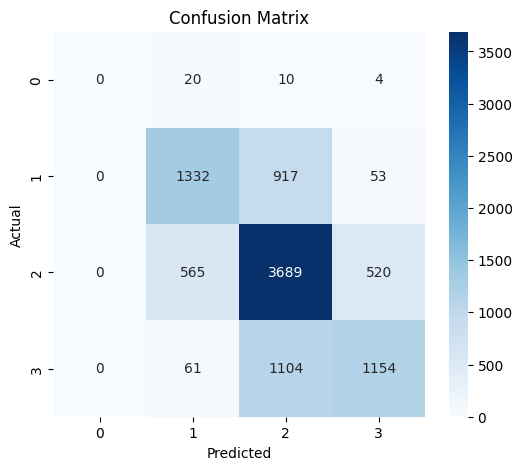

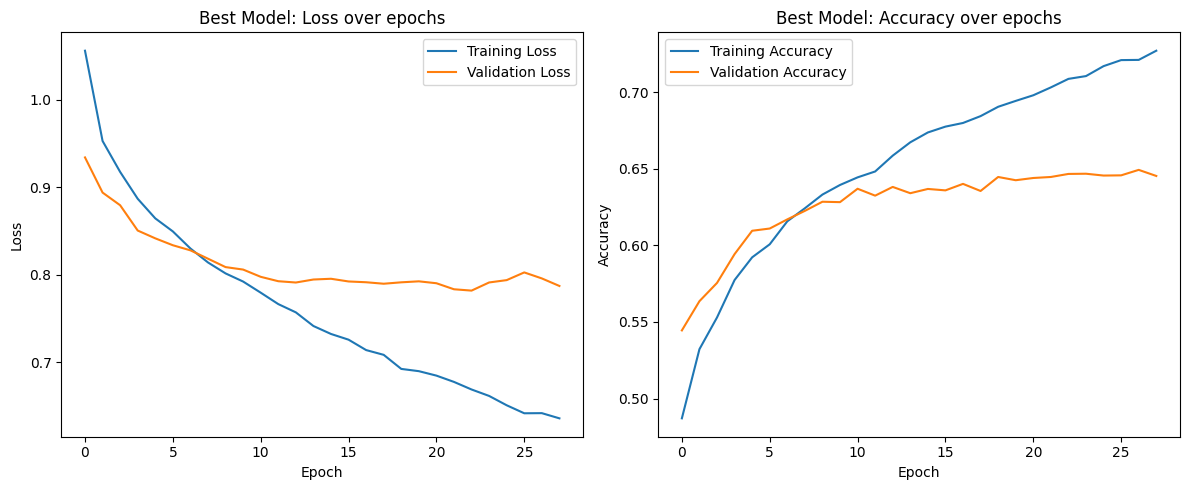

In [7]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test_class, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Best Model: Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Best Model: Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Comparison with a Fixed Baseline Model
For same metrics of accuracy, F1 score, precision, recall; Is our Keras tuned model really better in terms of performance?

In [8]:
# Comparison with baseline model (original hyperparameters)
print("\nTraining baseline model for comparison...")
baseline_model = Sequential([
    Dense(256, input_shape=(input_dim,), activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')  # 4 Popularity classes
])

baseline_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

baseline_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

baseline_history = baseline_model.fit(
    X_train, y_train_class,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[baseline_early_stopping]
)

baseline_preds = baseline_model.predict(X_test)
baseline_classes = np.argmax(baseline_preds, axis=1)
baseline_acc = accuracy_score(y_test_class, baseline_classes)

print(f'\nBaseline model accuracy: {baseline_acc:.4f}')
print(f'Tuned model accuracy: {acc:.4f}')
print(f'Improvement: {(acc - baseline_acc) * 100:.2f}%')


Training baseline model for comparison...
Epoch 1/50


/Users/cedricyee/Documents/GitHub/IS3107_Project/.conda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


943/943 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4697 - loss: 1.1180 - val_accuracy: 0.5638 - val_loss: 0.9136
Epoch 2/50
943/943 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5430 - loss: 0.9377 - val_accuracy: 0.5766 - val_loss: 0.8758
Epoch 3/50
943/943 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5783 - loss: 0.8879 - val_accuracy: 0.6007 - val_loss: 0.8515
Epoch 4/50
943/943 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5989 - loss: 0.8549 - val_accuracy: 0.5986 - val_loss: 0.8453
Epoch 5/50
943/943 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6114 - loss: 0.8320 - val_accuracy: 0.6132 - val_loss: 0.8240
Epoch 6/50
943/943 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6261 - loss: 0.8086 - val_accuracy: 0.6207 - val_loss: 0.8179
Epoch 7/50
943/943 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6423 - loss: 0.7844 - val_accuracy: 0.6202 - val_loss: 0.8126
Epoch 8/50
943/943 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6552 - loss: 0.7618 - val_accuracy: 0.6295 - val_

In [9]:
# Macro and Weighted scores for baseline model
baseline_precision_macro = precision_score(y_test_class, baseline_classes, average='macro')
baseline_recall_macro = recall_score(y_test_class, baseline_classes, average='macro')
baseline_f1_macro = f1_score(y_test_class, baseline_classes, average='macro')

baseline_precision_weighted = precision_score(y_test_class, baseline_classes, average='weighted')
baseline_recall_weighted = recall_score(y_test_class, baseline_classes, average='weighted')
baseline_f1_weighted = f1_score(y_test_class, baseline_classes, average='weighted')

print(" Baseline Model Metrics:")
print(f"Macro Precision: {baseline_precision_macro:.4f}")
print(f"Macro Recall: {baseline_recall_macro:.4f}")
print(f"Macro F1 Score: {baseline_f1_macro:.4f}")
print(f"Weighted Precision: {baseline_precision_weighted:.4f}")
print(f"Weighted Recall: {baseline_recall_weighted:.4f}")
print(f"Weighted F1 Score: {baseline_f1_weighted:.4f}")

 Baseline Model Metrics:
Macro Precision: 0.4855
Macro Recall: 0.4662
Macro F1 Score: 0.4729
Weighted Precision: 0.6461
Weighted Recall: 0.6481
Weighted F1 Score: 0.6435


/Users/cedricyee/Documents/GitHub/IS3107_Project/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/cedricyee/Documents/GitHub/IS3107_Project/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


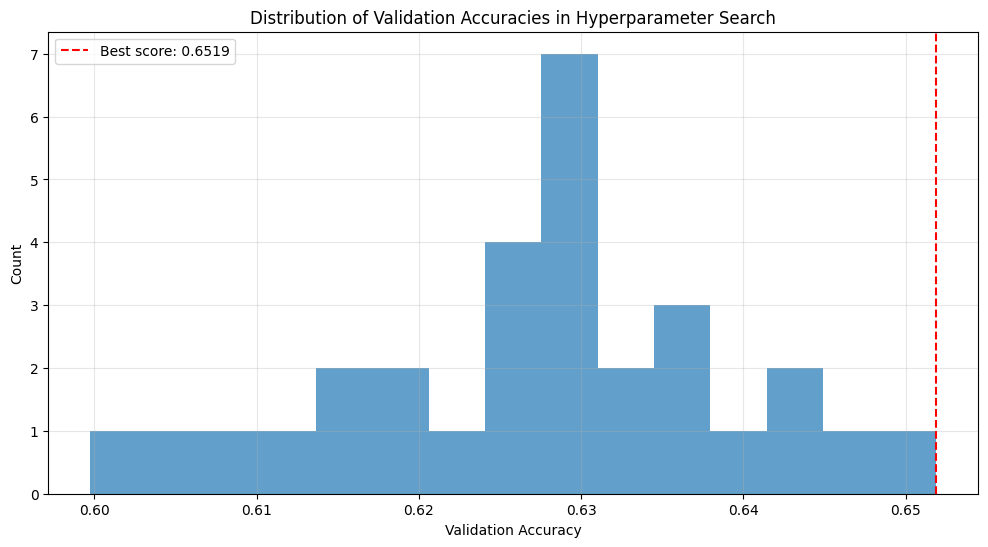

In [10]:
# Visualise trial results
plt.figure(figsize=(12, 6))
trial_scores = []
for trial in tuner.oracle.trials.values():
    if trial.score is not None:  
        trial_scores.append(trial.score)

plt.hist(trial_scores, bins=15, alpha=0.7)
plt.axvline(max(trial_scores), color='red', linestyle='--', 
            label=f'Best score: {max(trial_scores):.4f}')
plt.title('Distribution of Validation Accuracies in Hyperparameter Search')
plt.xlabel('Validation Accuracy')
plt.ylabel('Count')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Hyperparamter Tuning Results Statistics

Optimal hyperparameters (found through tuning):<br>
units_layer1: 224<br>
activation: relu<br>
batch_norm_1: False<br>
dropout_rate1: 0.7000000000000001<br>
units_layer2: 32<br>
batch_norm_2: True<br>
dropout_rate2: 0.30000000000000004<br>
units_layer3: 128<br>
batch_norm_3: True<br>
dropout_rate3: 0.2<br>
units_layer4: 32<br>
batch_size: 64<br>
learning_rate: 0.0018126809821095372<br>

Baseline hyperparamters:<br>
units_layer1: 256<br>
activation: relu<br>
batch_norm_1: True<br>
dropout_rate1: 0.5<br>
units_layer2: 128<br>
batch_norm_2: True<br>
dropout_rate2: 0.4<br>
units_layer3: 64<br>
batch_norm_3: True<br>
dropout_rate3: 0.3<br>
units_layer4: 32<br>
batch_size: 32<br>
learning_rate: 0.001<br><br>

Baseline model accuracy: 0.6481<br>
Tuned model accuracy: 0.6549<br>
Improvement: 0.68%<br>


### Evaluation of Tuning Results

The tuned model slightly outperformed the baseline, achieving a test accuracy of 65.49% compared to 64.81%. The tuned model introduces a more compact and selectively regularized architecture compared to the baseline. Notably, it starts with fewer units in the first layer (224 vs. 256) and applies a much higher dropout rate (0.7 vs. 0.5), suggesting a stronger emphasis on preventing overfitting early in the network. It also reduces the second layer dramatically (32 vs. 128), possibly to encourage feature compression, while increasing the third layer's size (128 vs. 64), creating a non-linear architecture. Batch normalization is disabled in the first layer for the tuned model, but kept in all other layers in both models. The tuned model doubles the batch size (64 vs. 32), which can lead to more stable gradient updates, and uses a slightly higher learning rate.

Although the improvement over the baseline was modest (only 0.68%), the tuning process allowed for a systematic exploration of the hyperparameter space, rather than relying on a fixed, pre-determined set of values, which is difficult to tell whether a given model's performance is truly optimal. Venturing into hyperparameter tuning enables comparison of different combinations of hyperparameters. ensuring the eventual selected configuration is closer to optimality for the task.

### Saving the NN Model
To be uploaded together with saved model pre-processing tools (StandardScalar, OneHotEncoder, TFIDF) to GCS bucket for modular deployment. \
See trained_models >> Historical_TrainedModels_LoadGCS.ipynb

In [ ]:
model_file_path = os.path.join(output_dir, 'tuned_NN_model.h5')
best_model.save(model_file_path)

In [13]:
from tensorflow.keras.models import load_model

loaded_model = load_model('trained_models/tuned_NN_model.h5')
loaded_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 224)            │       117,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         7,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,926 (523.15 KB)

 Trainable params: 133,604 (521.89 KB)

 Non-trainable params: 320 (1.25 KB)

 Optimizer params: 2 (12.00 B)